In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics



In [264]:
def random_forest(dt,target,depth = None, estimators = 100):
    X= dt.drop(target, 1)
    y = dt[target] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=10) #split the data
    model = RandomForestClassifier(max_depth = depth,n_estimators = estimators)
    model.fit(X_train, y_train)
    # Use score method to get accuracy of model
    score = model.score(X_test, y_test)
    print(score)
    
    #Get the prediction results
    y_predict = model.predict(X_test)
    y_pred_quant = model.predict_proba(X_test)[:, 1]
    y_pred_bin = model.predict(X_test)

    #Show the confusion matrix
    #Create the confusion matrics
    cm = metrics.confusion_matrix(y_test, y_pred_bin)
    
    feature_list = [i for i in X_train.columns]
    
    #Determine the feature importances
    # Get numerical feature importances
    importances = list(model.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
    #Extract the tree
    tree = model.estimators_[5]
    
    return score,cm,tree

In [237]:
#Read the data file and drop garbage columns
dt = pd.read_csv('cardiotocography.csv')
dt = dt.drop(['Unnamed: 23','CLASS'],axis = 1)
dt.iloc[:,10:22].describe()

,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


In [238]:
#detect and remove the variables with low variance
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold= 0.1)
sel.fit(dt)
vars = sel.get_support()
vars
#sel.get_params()


array([ True, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [239]:
#Determine the value distribution of each column to find out categorical variables
for i in range(len(dt.columns)):
    print(dt.iloc[:,i].value_counts())

133    136
130    111
122    109
138    103
125     91
128     85
120     78
144     77
142     77
132     76
136     72
140     70
134     67
135     65
146     62
127     60
137     59
129     57
123     56
131     56
143     56
148     52
121     44
139     39
141     39
126     38
145     37
115     28
150     26
110     21
149     18
152     17
119     17
112     16
147     14
151     14
159     12
114     11
158     10
124     10
118      9
154      8
106      7
116      5
157      4
156      4
117      2
160      1
Name: LB, dtype: int64
0.000    894
0.003    161
0.002    160
0.001    143
0.004    117
0.006    112
0.005    110
0.008    103
0.007     91
0.009     60
0.010     50
0.011     36
0.012     24
0.013     22
0.014     20
0.015      9
0.016      7
0.017      4
0.018      2
0.019      1
Name: AC, dtype: int64
0.000    1311
0.001     164
0.002     112
0.003      88
0.004      49
0.005      36
0.006      31
0.007      28
0.010      25
0.009      25
0.008      25
0.013      1

In [240]:
dt['Tendency'][dt['Tendency'] == -1] = 'left_asymmetric'
dt['Tendency'][dt['Tendency'] == 0] = 'symmetric'
dt['Tendency'][dt['Tendency'] == 1] = 'right_asymmetric'

dt['Tendency'] = dt['Tendency'].astype('object')

dt = pd.get_dummies(dt, drop_first=False)
dt.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Nmax,Nzeros,Mode,Mean,Median,Variance,NSP,Tendency_left_asymmetric,Tendency_right_asymmetric,Tendency_symmetric
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,2,0,120,137,121,73,2,0,1,0
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,6,1,141,136,140,12,1,0,0,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,5,1,141,135,138,13,1,0,0,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,11,0,137,134,137,13,1,0,1,0
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,9,0,137,136,138,11,1,0,1,0


In [241]:
#Count the values of target variable classes
dt.NSP.value_counts()

1    1655
2     295
3     176
Name: NSP, dtype: int64

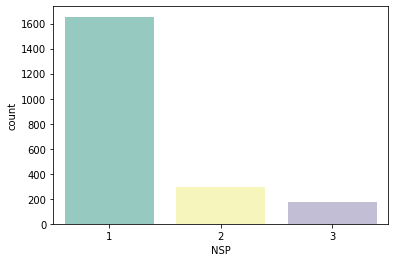

In [242]:
sns.countplot(x="NSP", data=dt, palette="Set3")
plt.show()

In [243]:
X= dt.drop('NSP', 1)
y = dt['NSP'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=10) #split the data

In [244]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
#model.pvalues

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [245]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

0.9436619718309859


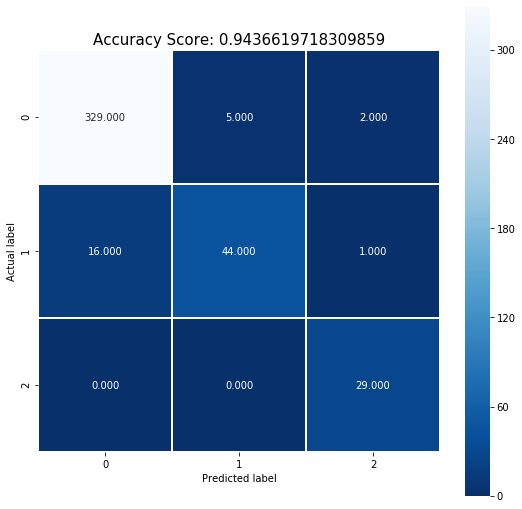

In [246]:
# Use score method to get accuracy of model
score = model.score(X_test, y_test)
print(score)

#Show the confusion matrix

#Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
#Create the confusion matrics
cm = metrics.confusion_matrix(y_test, y_pred_bin)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [247]:
#Feature selection using filter method
from sklearn.feature_selection import f_classif, chi2
chi2_score, chi_2_p_value = chi2(abs(X),y)
print('chi2 score        ', chi2_score)
print('chi2 p-value      ', chi_2_p_value)

chi2 score         [1.80585610e+02 1.55739803e+00 5.31225483e+00 3.42664542e-01
 5.83999842e-01 5.53068898e-02 1.50583254e+00 3.27041287e+03
 1.26218030e+02 1.79219887e+04 5.09803048e+02 2.25845212e+03
 1.50851383e+03 9.66431742e+00 5.12311140e+01 6.75934574e+00
 8.53916249e+02 8.40587696e+02 6.11460461e+02 1.18011255e+04
 1.00022052e+02 2.22357482e+01 2.46371364e+00]
chi2 p-value       [6.11410720e-040 4.59002779e-001 7.02196274e-002 8.42541575e-001
 7.46768595e-001 9.72725411e-001 4.70991011e-001 0.00000000e+000
 3.90933580e-028 0.00000000e+000 1.98460788e-111 0.00000000e+000
 0.00000000e+000 7.96929927e-003 7.50420940e-012 3.40585945e-002
 3.75355304e-186 2.94239609e-183 1.67127521e-133 0.00000000e+000
 1.90760055e-022 1.48446042e-005 2.91750347e-001]


In [248]:
#Feature selection using wrapping method
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
#Fit the model
lr.fit(X_train, y_train)
coef1 = lr.coef_
print(np.mean(abs(coef1)))
print(abs(coef1[1,:]))

0.05018159595292766
[5.28960273e-02 1.53009583e-03 3.34486088e-03 1.01529270e-03
 2.46084266e-04 4.03047988e-07 6.32482733e-05 4.12982117e-02
 2.05141152e-01 2.36344401e-02 3.66576031e-02 1.68384209e-02
 7.53775324e-03 2.43761742e-02 2.12804877e-01 5.15722349e-02
 4.80665351e-03 4.00711493e-02 1.08768435e-02 7.04137101e-04
 1.59834984e-02 4.83963352e-03 4.17246716e-02]


In [249]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators = 1000))
sel.fit(X_train, y_train)
feat = sel.get_support()
selected_feat= X_train.columns[(feat)]
print(len(selected_feat))
print(selected_feat)


9
Index(['AC', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Mode', 'Mean', 'Median'], dtype='object')


In [250]:
sellr = SelectFromModel(estimator=LogisticRegression()).fit(X_train, y_train)
f = sellr.get_support()
sf= X_train.columns[(f)]
print(sf)


Index(['FM', 'MSTV', 'Tendency_left_asymmetric', 'Tendency_right_asymmetric',
       'Tendency_symmetric'],
      dtype='object')


In [251]:
lrselected = dt[['FM', 'MSTV','NSP']]
lrselected.head()

,FM,MSTV,NSP
0,0.0,0.5,2
1,0.0,2.1,1
2,0.0,2.1,1
3,0.0,2.4,1
4,0.0,2.4,1


In [252]:
selected = dt[['DP', 'ASTV', 'MSTV', 'ALTV', 'Mode', 'Mean', 'Median','NSP']]
selected.head()

,DP,ASTV,MSTV,ALTV,Mode,Mean,Median,NSP
0,0.0,73,0.5,43,120,137,121,2
1,0.0,17,2.1,0,141,136,140,1
2,0.0,16,2.1,0,141,135,138,1
3,0.0,16,2.4,0,137,134,137,1
4,0.0,16,2.4,0,137,136,138,1


In [253]:
selected2 = dt[['AC', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Mode', 'Mean', 'Median','NSP']]
selected2.head()

,AC,DP,ASTV,MSTV,ALTV,MLTV,Mode,Mean,Median,NSP
0,0.000,0.0,73,0.5,43,2.4,120,137,121,2
1,0.006,0.0,17,2.1,0,10.4,141,136,140,1
2,0.003,0.0,16,2.1,0,13.4,141,135,138,1
3,0.003,0.0,16,2.4,0,23.0,137,134,137,1
4,0.007,0.0,16,2.4,0,19.9,137,136,138,1


In [254]:
sc,cm,tree = random_forest(selected,'NSP',depth = 10, estimators = 1000)
#print(sc)
print(cm)

0.9577464788732394
[[331   3   2]
 [ 11  49   1]
 [  1   0  28]]


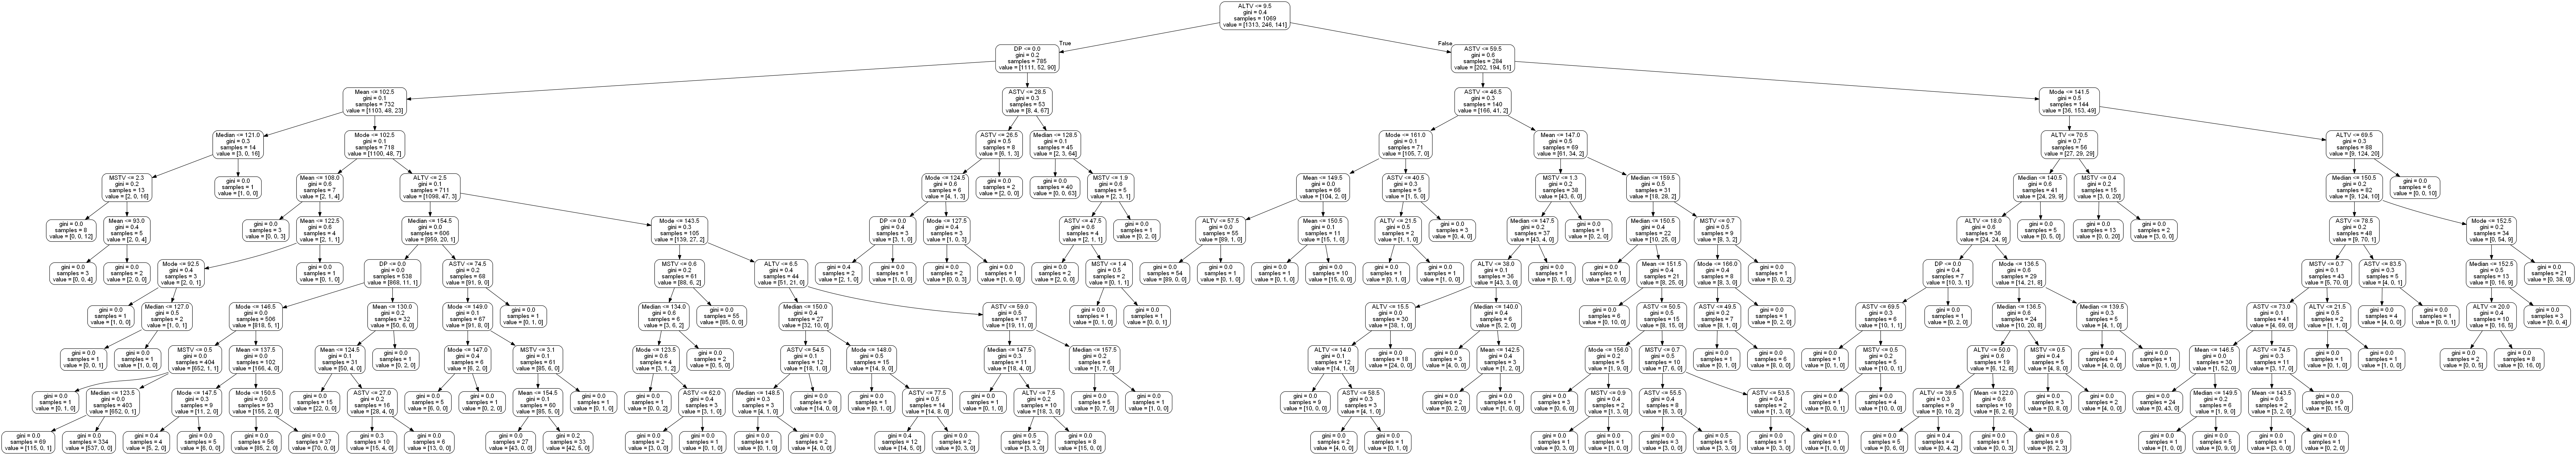

In [257]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# extract the feature names
sele = selected.drop(['NSP'], axis = 1)
feature_names = [i for i in sele.columns]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_names, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

from IPython.display import Image 
Image(filename = 'tree.png')

In [266]:
sc,cm,tree = random_forest(dt,'NSP',depth = 10, estimators = 1000)
#print(sc)
print(cm)

0.9624413145539906
Variable: ASTV                 Importance: 0.13
Variable: MSTV                 Importance: 0.11
Variable: ALTV                 Importance: 0.11
Variable: Mean                 Importance: 0.1
Variable: Mode                 Importance: 0.06
Variable: Median               Importance: 0.06
Variable: AC                   Importance: 0.05
Variable: DP                   Importance: 0.05
Variable: LB                   Importance: 0.04
Variable: UC                   Importance: 0.04
Variable: MLTV                 Importance: 0.04
Variable: Width                Importance: 0.04
Variable: Min                  Importance: 0.04
Variable: Variance             Importance: 0.04
Variable: Max                  Importance: 0.03
Variable: FM                   Importance: 0.02
Variable: Nmax                 Importance: 0.02
Variable: DL                   Importance: 0.01
Variable: DS                   Importance: 0.0
Variable: Nzeros               Importance: 0.0
Variable: Tendency_left_

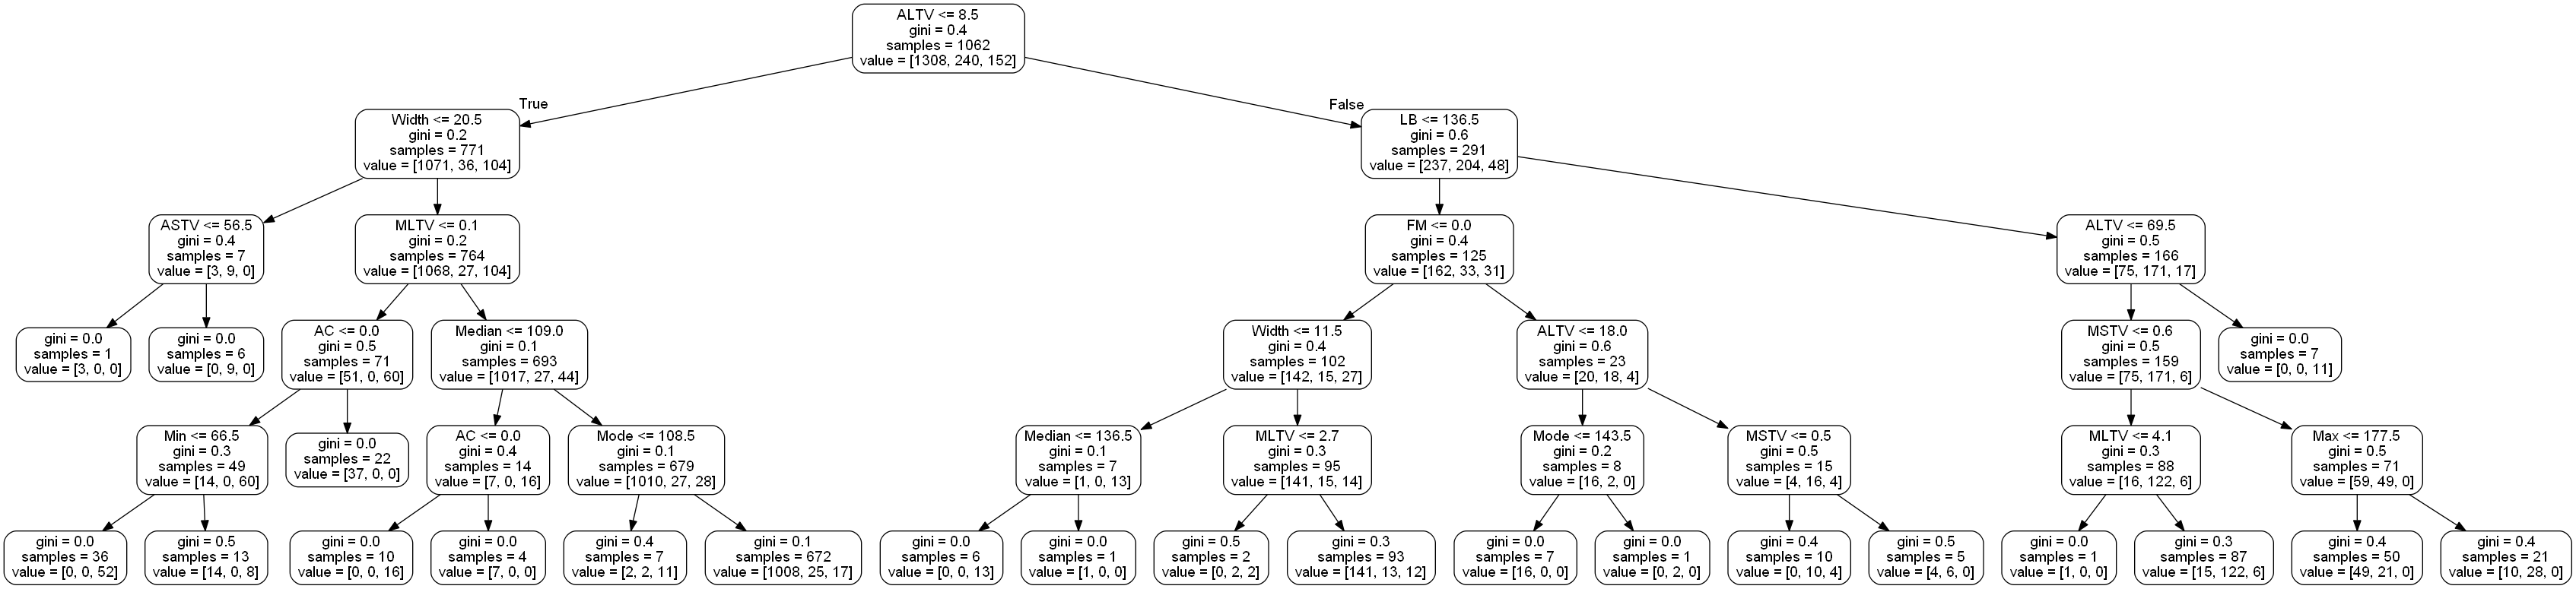

In [261]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# extract the feature names
sele = dt.drop(['NSP'], axis = 1)
feature_names = [i for i in sele.columns]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_names, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

from IPython.display import Image 
Image(filename = 'tree.png')

In [262]:
sc,cm,tree = random_forest(lrselected,'NSP',depth = 10, estimators = 1000)
#print(sc)
print(cm)

0.863849765258216
[[324   4   8]
 [ 27  30   4]
 [ 10   5  14]]


In [263]:
sc,cm,tree = random_forest(selected2,'NSP',depth = 10, estimators = 1000)
#print(sc)
print(cm)

0.960093896713615
[[329   5   2]
 [  8  52   1]
 [  1   0  28]]
